We consider the multidimensional negative logarithm function
$$
f(x) = - \sum_{i=1}^d \log (x_i),
$$
defined on the positive orthant $\{x \in \mathbb{R}^d : x_i > 0 \text{ for all } i\}$, but restricted to the open hypercube $C = (10^{-3}, 10^{-1})^d$ as discussed earlier. This time, we train the approximating ICNN on a training set $\tilde{X} \subseteq C$ obtained as $\tilde{X} = \phi_{\hat{v}}(\tilde{Y})$ from a uniform sample $\tilde{Y}$ in the gradient space $D$ through a neural network approximation $\phi_{\hat{v}}$ of the inverse of $\nabla f$. The neural network $\phi_{\theta} \colon \mathbb{R}^d \to \mathbb{R}^d$ used here has $\tanh$ activation and three hidden layers of sizes $[128,128]$.

For Table \ref{tab:3} it shows estimates of the $L^2$-approximation errors
$$
\|\nabla f \circ \phi_{\hat{v}} - \text{id}\|_{L^2(D , \text{Unif})} \quad \text{and} \quad \|h_{\hat{\theta}} - f^*\|_{L^2(D , \text{Unif})}
$$
along with the times in hours, minutes, and seconds it took to train $\phi_{\hat{v}}$ and $h_{\hat{\theta}}$.

It can be seen that the approximation of $f^*$ is more accurate compared to the direct sampling method. However, the time to train $h_{\hat{\theta}}$ has increased since indirect sampling involves an evaluation of the neural network $\phi_{\hat{v}}$ in the simulation of every random point $x \in \tilde{X}$.

Libraries: JAX.


In [ ]:
# !pip install optax

In [ ]:
# import jax
# import psutil
# import os

# # Function to get CPU info
# def get_cpu_info():
#     cpu_info = {
#         "Physical cores": psutil.cpu_count(logical=False),
#         "Total cores": psutil.cpu_count(logical=True),
#         "Max Frequency": f"{psutil.cpu_freq().max:.2f}Mhz",
#         "Current Frequency": f"{psutil.cpu_freq().current:.2f}Mhz",
#         "CPU Usage": f"{psutil.cpu_percent()}%"
#     }
#     return cpu_info

# # Function to get RAM info
# def get_ram_info():
#     svmem = psutil.virtual_memory()
#     ram_info = {
#         "Total": f"{svmem.total / (1024 ** 3):.2f} GB",
#         "Available": f"{svmem.available / (1024 ** 3):.2f} GB",
#         "Used": f"{svmem.used / (1024 ** 3):.2f} GB",
#         "Percentage": f"{svmem.percent}%"
#     }
#     return ram_info

# # Function to get GPU info using JAX
# def get_gpu_info():
#     gpu_devices = jax.devices()
#     if gpu_devices:
#         gpu_details = [str(device) for device in gpu_devices]
#         return {"GPU(s)": gpu_details}
#     else:
#         return {"GPU": "No GPU found"}

# # Display all info
# cpu_info = get_cpu_info()
# ram_info = get_ram_info()
# gpu_info = get_gpu_info()

# print("CPU Information:", cpu_info)
# print("RAM Information:", ram_info)
# print("GPU Information:", gpu_info)


In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, vmap, lax
from jax.tree_util import tree_leaves
import optax
import matplotlib.pyplot as plt
import yaml
import os
import time
import sys
import json
from scipy.io import savemat
from tqdm import tqdm
from collections import namedtuple
from functools import partial
from typing import Callable, Any, List

# Flax library imports
from flax import linen as nn
from flax.training import train_state


In [ ]:
DPI = 300 # dpi = 300  # Set DPI for higher quality images


In [ ]:
base_path = "/content/drive/MyDrive/ETH/Convex_conjugates/experiments_with_ICNN_2"
 # results of experiments with ICNN that use nonlinear transform to ensure convexity
sys.path.append(base_path)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Primal QUADRATIC:
def square(x):
    return jnp.reshape(jnp.sum(x*x, -1), ())
# Dual:
square_star_true = lambda x: jnp.sum(x*x, -1) / 4

#########################
# Primal NEGATIVE-ENTROPY
def negative_entropy(x):
    return jnp.reshape(jnp.sum(x * jnp.log(x), -1), ())
# Dual
negative_entropy_star_true = lambda x: jnp.sum(jnp.exp(x - 1), -1)

##########################
# Primal Negative Logarithm
def negative_logarithm(x):
    return -jnp.sum(jnp.log(x), axis=-1)

# Dual of the Negative Logarithm
def negative_logarithm_star_true(y):
    return -jnp.sum(jnp.log(-y), axis=-1) - y.shape[-1]



In [ ]:
class NonNegativeDense(nn.Module):
    features: int
    use_bias: bool = True
    dtype: Any = None
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros
    pre_transform: Callable = jnp.square # Optional pre-transformation

    @nn.compact
    def __call__(self, inputs):
        kernel_shape = (inputs.shape[-1], self.features)
        kernel = self.param('kernel', self.kernel_init, kernel_shape)
        # if self.pre_transform:
        kernel = self.pre_transform(kernel)  # Apply pre-transformation if any
         # Squaring the kernel to ensure non-negative weights
        y = jnp.dot(inputs, kernel)
        if self.use_bias:
            bias = self.param('bias', self.bias_init, (self.features,))
            y += bias
        return y

class ConvexNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i == 0:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x

def gelu(x):
    return 0.5 * x * (1 + jax.scipy.special.erf(x / jnp.sqrt(2)))

class FCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu# nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i > -1:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x



class BNFCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu #nn.relu  # Default activation; can be customized

    @nn.compact
    def __call__(self, x, train: bool = True):
        for i, width in enumerate(self.layer_widths):
            x = nn.Dense(features=width)(x)
            if i < len(self.layer_widths) - 1:  # Apply BatchNorm and activation to all but the last layer
                x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)
                x = self.activation(x)
        return x

# Configuration Parameters

- **experiment_name**: A string used to uniquely identify and track the experiment.
- **description**: A string describing the purpose or details of the experiment.
- **dim**: An integer representing the dimensionality of the input space.
- **layer_widths**: A list of integers specifying the number of units in each layer of the neural network.
- **num_epochs**: An integer representing the number of epochs to train the model.
- **batch_size**: An integer specifying the size of each training batch.
- **steps**: An integer representing the number of steps the model takes per batch, relevant when mini-batch optimization is used (i.e., when `use_grid` is False).
- **start**: A float or list of floats representing the start point(s) of the rectangular domain for the primal variables \( x \).
- **end**: A float or list of floats representing the end point(s) of the rectangular domain for the primal variables \( x \).
- **convrg_eps**: A float specifying the convergence threshold epsilon for stopping the training.
- **learning_rate**: A float representing the learning rate for the optimizer.
- **l2_regularization_coefficient**: A float for the L2 regularization term to prevent overfitting.
- **N_ae**: An integer specifying the number of epochs for pretraining an autoencoder, if applicable.
- **v_init_fn**: A callable function for initializing the parameters. For instance, it could be a function that generates random values within a certain range.
- **minval**: A float or list of floats indicating the minimum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **maxval**: A float or list of floats indicating the maximum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **y_func**: A callable function defining the behavior or computation of the dual variables \( y \).
- **y_func_star**: A callable function representing the true conjugate of \( y \).

## Domain Explanation

- **Primal Domain (`start` to `end`)**: The domain for the primal variables \( x \) is defined as \([start, end]^d\).
- **Dual Domain (`minval` to `maxval`)**: The domain for the dual variables \( y \) is defined as \([minval, maxval]^d\).

The correct transformation between the domains is $\nabla f: H \to K$  and $\nabla^{-1} f: K\to H$ realized below with approximate inverse mappings.

In [ ]:
LEARNING_RATE = 3e-4
ALPHA = 1e-8 #

Config = namedtuple("Config",
                    [
                     "experiment_name",        # Name of the experiment for tracking purposes
                     "description",            # Description of the experiment
                     "dim",                    # Dimensionality of the input space
                     "layer_widths",           # Widths of each layer in the neural network
                     "num_epochs",             # Number of epochs for training
                     "batch_size",             # Batch size for training
                     "steps",                  # Number of steps per batch (useful if use_grid is False)
                     "start",                  # Start point of the primal domain (rectangular domain start)
                     "end",                    # End point of the primal domain (rectangular domain end)
                     "convrg_eps",             # Convergence epsilon for stopping criterion
                    "ae_convrg_eps",             # Convergence epsilon for stopping criterion for ae
                     "learning_rate",          # Starting value of the learning rate for the optimizer
                     "learning_rate_ae",
                     "N_ae",                   # Number of epochs for autoencoder pretraining
                     "v_init_fn",              # Initialization function for the parameters
                     "minval",                 # Minimum value for the gradient domain (dual domain start)
                     "maxval",                 # Maximum value for the gradient domain (dual domain end)
                     "f_func",                 # Function definition for y (dual variables)
                     "f_func_star",             # True function conjugate for y
                     "train_sampling",         # use inverse sampling for train
                     "test_sampling"           # use inverse sampling for test
                    ])




In [ ]:
cfg = Config(
    experiment_name = "Negative_LOG_inverse_sampling_d=2",               # Name of the experiment for tracking purposes
    description = "Negative_LOG_inverse_sampling_d=2",        # Description of the experiment
    dim = 2,                               # Dimensionality of the input space
    layer_widths = (256, 256),           # Widths of each layer in the neural network
    num_epochs = 200000,                   # Number of epochs for training
    N_ae = 10000,                           # Number of epochs for autoencoder pretraining
    batch_size = 6200,                      # Batch size for training
    steps = 1,                              # Number of steps per batch (useful if use_grid is False)
    start = 0.001,                              # Start point of the primal domain (rectangular domain start point)
    end = 0.1,                                # End point of the primal domain (rectangular domain end point)
    minval = -1000,                             # Minimum value for the gradient domain (dual domain start)
    maxval = -10,                            # Maximum value for the gradient domain (dual domain end)
    ae_convrg_eps = 1e-9,                   #  Convergence epsilon for  ae stopping
    convrg_eps = 1e-5,                      # Convergence epsilon for stopping criterion
    learning_rate = 3e-3,                   # Learning rate for the optimizer
    learning_rate_ae  = 3e-4,
    v_init_fn = "V_INIT_Uniform",           # Initialization function for the parameters
    f_func = "negative_logarithm",            # Function definition for f (dual variables)
    f_func_star = "negative_logarithm_star_true", # True function conjugate for f*
    train_sampling = True, # use inverse sampling for train
    test_sampling = True, # use inverse sampling for test
)


# path_to_results_and_cfgs = os.path.join(base_path, "Experiment_test")

# # Path to the YAML file
# config_path = os.path.join(path_to_results_and_cfgs, 'config.yaml')

# # Save the config to the YAML file
# save_config_to_yaml(cfg, config_path)

In [ ]:
# Map the string names to the actual functions
function_mapping = {
    "square": square,
    "square_star_true" : square_star_true,
    "negative_entropy": negative_entropy,
    "negative_entropy_star_true" : negative_entropy_star_true,
    "negative_logarithm": negative_logarithm,
    "negative_logarithm_star_true": negative_logarithm_star_true,
    # Add other functions...
}




# Some saving/loading utils:

In [ ]:
def save_statistics(statistics, path_to_save, filename):
    # Convert JAX arrays to NumPy arrays, NumPy arrays to lists, and float32 to float
    serializable_stats = {}
    for k, v in statistics.items():
        if isinstance(v, (jnp.ndarray, np.ndarray)):
            v = jax.device_get(v).tolist()
        elif isinstance(v, np.float32):
            v = float(v)
        serializable_stats[k] = v

    print("Statistics:")
    for key, value in statistics.items():
        print(f"  {key}: {value}")

    full_path = os.path.join(path_to_save, filename)
    with open(full_path, 'w') as file:
        json.dump(serializable_stats, file)


In [ ]:
def save_config_to_yaml(config, path):
    with open(path, 'w') as file:
        yaml.dump(dict(config._asdict()), file)

# Some plotting/statistics utils:

In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

def plot_results(d, eval_grad_f_x, preds, vmap_f_star_true, state, const_val, train_loss_list, eval_loss_list):
    """
    Plots evaluation results and calculates residuals.

    Args:
        d (int): Dimensionality of the input space.
        eval_grad_f_x (array): Evaluated gradient values.
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        state (train_state.TrainState): Training state containing model parameters.
        const_val (float): Constant value for plotting higher dimensions.
        Loss (list): List of loss values over epochs.
    """

    dpi = 100  # You can adjust DPI if needed

    font_size = 20  # Large font size for titles, labels, and legends

    if d == 1:
        # Sort and plot for 1D
        eval_grad_f_x = np.squeeze(eval_grad_f_x)
        indices = np.argsort(eval_grad_f_x)
        eval_grad_f_x, preds = eval_grad_f_x[indices], preds.flatten()[indices].reshape(-1, 1)
        plt.figure(dpi=dpi)
        plt.plot(eval_grad_f_x, preds, lw=3, label='Predictions')
        plt.plot(eval_grad_f_x, vmap_f_star_true(eval_grad_f_x.reshape(-1, 1)), lw=3, label='True Conjugate')
        plt.xlabel('eval_grad_f_x', fontsize=font_size)
        plt.ylabel('Function Values', fontsize=font_size)
        plt.title('Sorted Points and Function Values', fontsize=font_size)
        plt.legend(fontsize=font_size)
        plt.grid(True)
        plt.show()

        # Calculate and print RMSE (residual)
        accuracy = 1 / np.sqrt(eval_grad_f_x.shape[0]) * jnp.linalg.norm(preds.reshape(-1, 1) - vmap_f_star_true(eval_grad_f_x).reshape(-1, 1))
        print("Residual:", accuracy)

    if d >= 2:
        # Scatter plot for first two components in 2D+
        start = jnp.min(eval_grad_f_x)
        end = jnp.max(eval_grad_f_x)
        plt.figure(dpi=dpi)
        plt.scatter(eval_grad_f_x[:, 0], eval_grad_f_x[:, 1], c='red', marker='o', s=30)  # Increased marker size
        plt.xlabel(r'$y_1$', fontsize=font_size)
        plt.ylabel(r'$y_2$', fontsize=font_size)
        plt.title('Scatter Plot of sampling in D', fontsize=font_size)
        plt.grid(True)
        plt.show()

        def generate_1D_line_in_dD_space(axis, const_val, start, end, num_points=100, d=d):
            x = jnp.linspace(start, end, num_points)
            line_dD = jnp.ones((num_points, d)) * const_val
            line_dD = line_dD.at[:, axis].set(x)
            return line_dD

        def calculate_and_plot(axis, const_val):
            line_dD = generate_1D_line_in_dD_space(axis, const_val, start, end)
            f_x = state.apply_fn({'params': state.params}, line_dD)
            f_star_true_x = vmap_f_star_true(line_dD)

            # Calculate and print RMSE along the axis
            accuracy = 1 / np.sqrt(line_dD.shape[0]) * jnp.linalg.norm(f_x.reshape(-1, 1) - f_star_true_x.reshape(-1, 1))
            print("Residual along axis {} @ value = {}: {}".format(axis, const_val, accuracy))

            plt.figure(dpi=dpi)
            plt.plot(line_dD[:, axis], f_x, lw=4, label=r'$g_{\hat{\theta}}$')
            plt.plot(line_dD[:, axis], f_star_true_x, lw=4,  ls='--', label='True Conjugate')
            ax = axis+1
            print('ax = ', ax)
            ax_name = f'$y_{{{ax}}}$'
            plt.xlabel(rf'{ax_name}', fontsize=font_size)
            plt.title('Numerical and Analytical DLT along axis {}'.format(axis+1), fontsize=font_size)
            plt.legend(fontsize=font_size)
            plt.grid(True)
            plt.show()

        calculate_and_plot(axis=0, const_val=const_val)
        calculate_and_plot(axis=1, const_val=const_val)

    # Plot training loss over epochs
    plt.figure(dpi=100)
    plt.plot(train_loss_list, lw=3, label='Training Loss')
    plt.plot(eval_loss_list, lw=3, label='Evaluation Loss')
    plt.xlabel('Epochs', fontsize=font_size)
    plt.ylabel('Loss', fontsize=font_size)
    plt.title('Training and Evaluation Loss Over Epochs', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid(True)
    plt.show()


In [ ]:
def descriptive_statistics(data, name="Data"):
    """Returns descriptive statistics for the given data as a dictionary."""
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    minimum = np.min(data, axis=0)
    maximum = np.max(data, axis=0)
    shape = data.shape

    statistics = {
        "name": name,
        "shape": shape,
        "mean": mean,
        "std_dev": std_dev,
        "min": minimum,
        "max": maximum
    }

    return statistics


In [ ]:
def calculate_statistics(y, preds, vmap_f_star_true, cfg = cfg):
    """
    Calculate various statistics for evaluating the model's performance.

    Args:
        y (array): Batch of  values from gradiant space (from set D).
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        loss_value (float): The loss value from the model.

    Returns:
        acc (float): Root Mean Squared Error (RMSE) between predictions and true values, excluding infinities.
        max_acc (float): Maximum error between predictions and true values, excluding infinities.
        res (float): Square root of the loss value.
        mre (float): Mean Relative Error (MRE) between predictions and true values, excluding infinities.
    """
    # Calculate true conjugate values
    f_star_values = vmap_f_star_true(y)

    # Identify points where vmap_f_star_true gives infinity
    is_finite = jnp.isfinite(f_star_values)

    # Apply the mask to filter out infinite points
    finite_preds = preds[is_finite]
    finite_f_star_values = f_star_values[is_finite]

    # Reshape for calculation
    finite_preds_reshaped = finite_preds.reshape(-1, 1)
    finite_f_star_values_reshaped = finite_f_star_values.reshape(-1, 1)

    # Calculate RMSE excluding infinite points

    acc = 1 / np.sqrt(finite_preds_reshaped.shape[0]) * jnp.linalg.norm(finite_preds_reshaped - finite_f_star_values_reshaped)

    # Calculate maximum error excluding infinite points
    max_acc = jnp.max(jnp.abs(finite_preds_reshaped - finite_f_star_values_reshaped))

    # Calculate Mean Relative Error (MRE), avoiding division by zero
    relative_errors = jnp.where(finite_f_star_values_reshaped != 0,
                                jnp.abs((finite_preds_reshaped - finite_f_star_values_reshaped) / finite_f_star_values_reshaped),
                                0)
    mre = jnp.mean(relative_errors)

    # Calculate square root of the loss value

    # if loss_value is not None:
    #     res = np.sqrt(loss_value)
    # else:
    #     res = None  # Or handle the None case differently as need

    return acc, max_acc, mre


# RUN **SINGLE** EXPERIMENT

## JAX tricks:

We vmap all the funcitons for efficient computing.

In [ ]:
initial_key = jax.random.PRNGKey(0)

f = function_mapping[cfg.f_func]
f_star_true =  function_mapping[cfg.f_func_star]

# Wrapping the modified objective function with grad, jit, and vmap
grad_f_fn = jax.grad(f, argnums=0)
grad_f = jax.jit(grad_f_fn)

# Vectorization for processing batches of inputs "vmap_f_epsilon"
vmap_grad_f = vmap(grad_f, in_axes = 0)
vmap_f = vmap(f, in_axes = 0)
vmap_f_star_true = vmap(f_star_true, in_axes = 0)


## Approximate Inverse Mapping

Since our goal is to approximate $f^*(y)$, in some cases, it might be beneficial to train the model on samples $\{y_i\}$ that have some desired distribution $\nu$. For example, $\nu$ can be a uniform distribution on some compact subset $K$ of $D$. However, if we sample $d$-dimensional $x$ uniformly, then the gradient $\nabla f(x)$ will (generally) not have a $d$-dimensional uniform distribution.

The desired $x$-sample can be obtained as $\{(\nabla f)^{-1}(z)\}$, where $(\nabla f)^{-1}(z)$ is some element from the preimage, and $z$ is sampled according to $\nu$ on $K$. In some cases, the inverse mapping $(\nabla f)^{-1}$ exists and can be found analytically; however, generally, we have to rely on approximations.

One approach to address this problem is to prelearn the domain. This involves learning the domain of the mapping in advance to ensure accurate and efficient sampling.

To address this problem, we introduce the concept which we call \textit{the approximate inverse mapping}. The idea is as follows:
Let $\Psi:\mathbb{R}^d \to \mathbb{R}^d$ be some mapping.

1. We can learn $\Psi^{-1}$ (preimage) as a decoder in an "autoencoder type" architecture:
$$
x \xrightarrow{\mathfrak{e}} \Psi(x) \xrightarrow{\mathfrak{d}} x
$$
where the encoder $\mathfrak{e}$ is set equal to $\Psi$. The decoder part, $\mathfrak{d}: \psi \mapsto x$, will provide an approximate inverse to the mapping $\Psi$ if $\Psi$ is invertible, and an element from the preimage otherwise.

2. We can learn $\Psi^{-1}$ (preimage) as an encoder in an "autoencoder type" architecture:
$$
y \xrightarrow{\mathfrak{e}} \Psi^{-1}(y) \xrightarrow{\mathfrak{d}} y
$$
where the decoder $\mathfrak{d}$ is set equal to $\Psi$. The encoder part, $\mathfrak{e}: y \mapsto x$, will provide an approximate inverse to the mapping $\Psi$ if $\Psi$ is invertible, and an element from the preimage otherwise.

If the domain of $\Psi$ is known to be large (a totally safe option is the whole $\mathbb{R}^d$, otherwise one needs to sample with rejection), then we can safely use the second variant, which is generally more convenient. Otherwise, the first option is safer.

As a result, one can sample from the distribution $\nu$ in the $\{\psi\}$ space so that $\mathfrak{d}(\psi)$ generates $\{x\}$-samples, which will (approximately) have the desired property.

In some cases, when $\Psi$ is invertible, it is also possible to learn the encoder and decoder simultaneously, which can improve efficiency and convergence.

$$\begin{cases}
x \xrightarrow{\nabla} \Psi(x) \xrightarrow{\mathfrak{d}} x \\
y \xrightarrow{\mathfrak{e}} \Psi^{-1}(y) \xrightarrow{\nabla} y
\end{cases},$$

enforcing $\mathfrak{d} = \mathfrak{e}$. In our experiments, this improved the domain learning for $\mathfrak{e}$ and learning speed. If necessary, it can be easily adjusted to include cases 1 and 2.

### Training Inverse of Mapping $G$

To adapt the model to learn the inverse of a composite mapping $G = g \circ \Psi$, where $g: \mathbb{R} \to \mathbb{R}$ is a predefined function such as $g(y) = \frac{1}{y}$, follow these steps:

1. **Define $G$ and $g$**:
   $$
   G(x) = g(\Psi(x))
   $$
   For example, if $g(y) = \frac{1}{y}$, then $G(x) = \frac{1}{\Psi(x)}$.

2. **Modify the Loss Function**:
   Update the loss function to incorporate $G$ and its inverse $G^{-1}$.

3. **Train the Model**:
   Train the model to learn the inverse of $G$, denoted as $G^{-1}$. Once $G^{-1}$ is learned, $\Psi^{-1}$ can be restored using $G^{-1}$ and $g$:
   $$
   \Psi^{-1}(y) = G^{-1}(g(y))
   $$


In [ ]:
# # Example training loop setup
n_samples = cfg.batch_size * 10
batch_size = cfg.batch_size

import time



In [ ]:
from base64 import encode
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
import os
from flax.training import train_state
from jax import grad, vmap
from functools import partial
from jax import random
import numpy as np
import pickle
import time

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    d: int  # Dimensionality

    def setup(self):
        self.fc1 = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.fc2 = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.fc3 = nn.Dense(self.d, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.tanh = nn.tanh

    def __call__(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Define gradient mapping
def h(x, f):
    return grad(f)(x)

# Define function g and operator G
def g(y):
    return -1/y

def G(x, f):
    return g(h(x, f))

# Define primal_function
primal_function = f

# Initialize the autoencoder
d = cfg.dim  # Dimensionality
key = random.PRNGKey(0)
autoencoder = Autoencoder(d=d)
x_dummy = jnp.zeros((1, d))
params = autoencoder.init(key, x_dummy)['params']

# Uniform sampling random generator
@partial(jax.jit, static_argnums=(1, 2))
def uniform_sampling_random_generator(key, batch_size, dim, minval, maxval):
    return random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)

# Create the optimizer
lr_schedule = optax.exponential_decay(
    init_value=1e-5,
    transition_steps=1000,
    decay_rate=0.95,
    staircase=True
)
optimizer = optax.adam(lr_schedule)

encoder_loss_factor = 1e1/cfg.start
decoder_loss_factor = 1e1/cfg.start

# Initialize training state
ae_state = train_state.TrainState.create(
    apply_fn=autoencoder.apply,
    params=params,
    tx=optimizer
)

# Estimate y-space range
def estimate_y_space_range(key, num_samples, batch_size, dim):
    x_samples = []
    for _ in range(num_samples // batch_size):
        key, subkey = random.split(key)
        x_samples.append(uniform_sampling_random_generator(subkey, batch_size, dim, cfg.start, cfg.end))
    x_samples = jnp.concatenate(x_samples, axis=0)
    y_samples = jax.vmap(lambda xi: h(xi, primal_function))(x_samples)
    min_y = jnp.min(y_samples, axis=0)
    max_y = jnp.max(y_samples, axis=0)
    return min_y, max_y

# Estimate the range for y-space
# min_y, max_y = estimate_y_space_range(key, cfg.batch_size * 10, cfg.batch_size, d)
min_y, max_y = cfg.minval, cfg.maxval

# Loss function for training
def loss_fn(params, x, z):
    # Encode x to get encoding target
    encoding_target = jax.vmap(G, in_axes=(0, None))(x, primal_function)

    # Decode the encoding target to reconstruct x
    decoding = autoencoder.apply({'params': params}, encoding_target)

    # Calculate the decoder loss as the mean squared error between x and its reconstruction
    decoder_loss = jnp.mean(jnp.square((decoding - x)*decoder_loss_factor))

    # Decode z to get decoding target
    decoding_target = autoencoder.apply({'params': params}, z)

    # Re-encode the decoding target to reconstruct z
    reencoded = jax.vmap(G, in_axes=(0, None))(decoding_target, primal_function)

    # Create a mask to filter out non-finite values in reencoded and z
    finite_mask = jnp.logical_and(jnp.isfinite(reencoded).all(axis=1), jnp.isfinite(z).all(axis=1))

    # Apply the mask to reencoded and z
    reencoded = jnp.where(finite_mask[:, None], reencoded, jnp.zeros_like(reencoded))
    z = jnp.where(finite_mask[:, None], z, jnp.zeros_like(z))

    # Calculate the encoder loss as the mean squared error between z and its reconstruction
    encoder_loss = jnp.mean(jnp.square((reencoded - z)*encoder_loss_factor)) if reencoded.size > 0 else 0.0

    # Return individual losses and their sum
    return decoder_loss, encoder_loss, (decoder_loss + encoder_loss)

# Gradient function
@jax.jit
def train_step(ae_state, x, z):
    def loss(params):
        return loss_fn(params, x, z)[2]
    grads = grad(loss)(ae_state.params)
    return ae_state.apply_gradients(grads=grads)

# Save model function
def save_model(ae_state, path):
    with open(path, 'wb') as f:
        pickle.dump(ae_state.params, f)

# Load model function
def load_model(path, ae_state):
    with open(path, 'rb') as f:
        params = pickle.load(f)
    ae_state = ae_state.replace(params=params)
    return ae_state

# Psi^-1 generator
@partial(jax.jit, static_argnums=(1, 2, 3, 4))
def psi_inv_generator(key, batch_size, dim, minval, maxval):
    y_samples = uniform_sampling_random_generator(key, batch_size, dim, minval, maxval)
    z_samples = g(y_samples)
    return autoencoder.apply({'params': params}, z_samples)

# Plotting function to observe the progress
def plot_progress(uniform_samples_z, gradient_mapped_encoded_samples, x_batch, encoded_samples_x, decoded_samples_x, Psi_inv_samples, epoch, current_lr, decoder_loss, encoder_loss, total_loss, z_samples, save_fig=True):
    if d >= 2:
        fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=DPI)

        # Plot 1: Uniform in z-space vs Gradient Mapped Samples
        axes[0].scatter(uniform_samples_z[:, 0], uniform_samples_z[:, 1], color='blue', alpha=0.6, label='Uniform Samples in z-space')
        axes[0].scatter(gradient_mapped_encoded_samples[:, 0], gradient_mapped_encoded_samples[:, 1], color='red', alpha=0.6, label='Gradient Mapped Decoded Samples')
        axes[0].set_xlabel('Component 0 of z')
        axes[0].set_ylabel('Component 1 of z')
        axes[0].set_title(f'Epoch {epoch+1} - Uniform in z-space vs Gradient Mapped Samples\nLearning Rate: {current_lr:.6f}\n Encoder Loss: {encoder_loss:.4f}, Total Loss: {total_loss:.4f}')
        axes[0].legend(loc='lower right')

        # Plot 2: Decoded Samples and x_batch
        axes[1].scatter(x_batch[:, 0], x_batch[:, 1], color='blue', alpha=0.6, label='x_batch Samples')
        axes[1].scatter(decoded_samples_x[:, 0], decoded_samples_x[:, 1], color='green', alpha=0.6, label='Decoded Samples')
        axes[1].set_xlabel('Component 0 of x')
        axes[1].set_ylabel('Component 1 of x')
        axes[1].set_title(f'Epoch {epoch+1} - Decoded Samples\nLearning Rate: {current_lr:.6f}\nDecoder Loss: {decoder_loss:.4f}, Total Loss: {total_loss:.4f}')
        axes[1].legend(loc='lower right')

        # Plot 3: Psi^-1(g(y))
        if z_samples is not None:
            axes[2].scatter(Psi_inv_samples[:, 0], Psi_inv_samples[:, 1], color='orange', alpha=0.6, label='Psi^{-1}(g(y)) Samples')
        axes[2].set_xlabel('Component 0 of x')
        axes[2].set_ylabel('Component 1 of x')
        axes[2].set_title(f'Epoch {epoch+1} - Psi^{-1}(g(y))\nLearning Rate: {current_lr:.6f}')
        axes[2].legend(loc='lower right')

        if save_fig:
            plt.savefig(f'/content/plots/epoch_{epoch+1}.png')
        plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_gradient_space(image_under_grad_f_of_Psi_inv_samples, y_batch, h_x_batch, epoch, save_fig=False):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=300)
    ax[0].scatter(y_batch[:,0], y_batch[:,1], label='Unif. sampling in gradient space')
    ax[0].scatter(image_under_grad_f_of_Psi_inv_samples[:,0], image_under_grad_f_of_Psi_inv_samples[:,1], label='Approximate inverse sampling')

    ax[0].set_xlabel('Component 0 of y')
    ax[0].set_ylabel('Component 1 of y')
    ax[0].set_title(f'Epoch {epoch+1} - Gradient Space')
    ax[0].legend(loc='lower right')

    ax[1].scatter(y_batch[:,0], y_batch[:,1], label='Unif. sampling in gradient space' )
    ax[1].scatter(h_x_batch[:,0], h_x_batch[:,1], label=r'Direct sampling: $y \sim \nabla f \circ \mathrm{Unif}$')

    ax[1].set_xlabel('Component 0 of y')
    ax[1].set_ylabel('Component 1 of y')
    ax[1].legend(loc='lower right')

    if save_fig:
        plt.savefig(f'/content/plots/gradient_space_epoch_{epoch+1}.png')

    plt.show()



# Training function
def train_autoencoder(ae_state, key, num_epochs, batch_size, start_epoch=0):
    for epoch in range(start_epoch, start_epoch + num_epochs):

        key, subkey = random.split(key)
        x_batch = uniform_sampling_random_generator(subkey, batch_size, d, cfg.start, cfg.end)

        key, subkey = random.split(key)
        y_batch = uniform_sampling_random_generator(subkey, batch_size, d, min_y, max_y)
        a = jnp.minimum(g(min_y), g(max_y))
        b = jnp.maximum(g(min_y), g(max_y))
        z_batch = uniform_sampling_random_generator(subkey, batch_size, d, a, b)

        ae_state = train_step(ae_state, x_batch, z_batch)

        if epoch == start_epoch + num_epochs - 1:
            save_model(ae_state, f'/content/model_weights/{cfg.f_func}_autoencoder_epoch_{epoch+1}.pkl')

        if epoch % 5000 == 0:
            print("=========================================")
            print(f"Epoch [{epoch + 1}/{start_epoch + num_epochs}]")
            print("=========================================")
            z_samples = jax.vmap(G, in_axes=(0, None))(x_batch, primal_function)
            decoded_samples_x = autoencoder.apply({'params': ae_state.params}, z_samples)
            encoded_samples_x = autoencoder.apply({'params': ae_state.params}, z_batch)
            Psi_inv_samples = autoencoder.apply({'params': ae_state.params}, g(y_batch))

            image_under_grad_f_of_Psi_inv_samples = jax.vmap(h, in_axes=(0, None))(Psi_inv_samples, primal_function)

            h_x_batch = jax.vmap(h, in_axes=(0, None))(x_batch, primal_function)

            plot_gradient_space(image_under_grad_f_of_Psi_inv_samples, y_batch, h_x_batch , epoch, save_fig=False)

            gradient_mapped_encoded_samples = jax.vmap(G, in_axes=(0, None))(encoded_samples_x, primal_function)

            decoder_loss, encoder_loss, total_loss = loss_fn(ae_state.params, x_batch, z_batch)
            current_lr = lr_schedule(epoch)
            print(f"Epoch [{epoch + 1}/{start_epoch + num_epochs}], Total Loss: {total_loss:.8f}, Decoder Loss: {decoder_loss:.8f}, Encoder Loss: {encoder_loss:.8f}, Learning Rate: {current_lr:.6f}")

            plot_progress(z_batch, gradient_mapped_encoded_samples, x_batch, encoded_samples_x, decoded_samples_x, Psi_inv_samples, epoch, current_lr, decoder_loss, encoder_loss, total_loss, z_samples)

            # ae_loss = total_loss
            normalization_coef = (max_y - min_y)*jnp.sqrt(d)/2
            ae_loss = (jnp.mean(jnp.square(image_under_grad_f_of_Psi_inv_samples - y_batch)))/normalization_coef # ae_loss for the right inverse; normalization to make it compaprable with left inverse, due to diffferent domains

    return ae_state, ae_loss

# Create the directory to save model weights if it does not exist
model_weights_path = '/content/model_weights'
os.makedirs(model_weights_path, exist_ok=True)

# Optionally create directory to save plots
plots_path = '/content/plots'
os.makedirs(plots_path, exist_ok=True)

# Calculate runtime
start_time = time.time()

# Train the autoencoder
num_epochs_total = 20000  # cfg.num_epochs
ae_state, ae_loss = train_autoencoder(ae_state, key, num_epochs_total, cfg.batch_size)

end_time = time.time()
ae_runtime = end_time - start_time

print(f"Autoencoder training runtime: {ae_runtime:.2f} seconds")
print(f"Autoencoder loss: {ae_loss:.2f} ")


In [ ]:
# Define the function to apply the encoder
def apply_encoder(params, inputs):
    return  autoencoder.apply({'params': ae_state.params}, g(inputs)) #autoencoder.apply({'params': params}, inputs)

# Generate y_samples uniformly
def generate_y_samples_uniformly(key, batch_size, dim, minval, maxval):
    return random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)

# Placeholder for psi function
def psi(x):
    return grad(primal_function)(x)


# Small sample exercise
sample_size = 1
y_samples = generate_y_samples_uniformly(random.PRNGKey(25), sample_size, cfg.dim, cfg.minval, cfg.maxval)
x_samples = apply_encoder(ae_state.params, y_samples)
y_reconstructed = jax.vmap(h, in_axes=(0, None))(x_samples, primal_function) #jax.vmap(psi, in_axes=(0,))(x_samples)
print("y-sample       x-sample       y-reconstructed")
for y, x, y_rec in zip(y_samples, x_samples, y_reconstructed):
    print(f"{y} -> {x} -> {y_rec}")



In [ ]:
encoder_params = ae_state.params

# After training, perform the small sample exercise to verify the encoder's generalization
sample_size = 2
y_samples = generate_y_samples_uniformly(key, sample_size, cfg.dim, cfg.minval, cfg.maxval)

# Apply encoder to y-samples to get x-samples
x_samples = apply_encoder(encoder_params, y_samples)

# Apply gradient mapping to x-samples to get y-reconstructed
y_reconstructed = jax.vmap(psi, in_axes=(0,))(x_samples)

# Print the results after training
print("After Training:")
print("y-sample       x-sample       y-reconstructed")
for y, x, y_rec in zip(y_samples, x_samples, y_reconstructed):
    print(f"{y} -> {x} -> {y_rec}")

In [ ]:
import jax
import jax.numpy as jnp

def x_uniform_sampling_generator(cfg, key, minval_x=None, maxval_x=None):
    minval_x = minval_x if minval_x is not None else cfg.start
    maxval_x = maxval_x if maxval_x is not None else cfg.end
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_x, maxval=maxval_x)
        yield U

def y_uniform_sampling_generator(cfg, key, minval_y=None, maxval_y=None):
    minval_y = minval_y if minval_y is not None else cfg.minval
    maxval_y = maxval_y if maxval_y is not None else cfg.maxval
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_y, maxval=maxval_y)
        yield U

def create_inverse_uniform_sampling_random_generator(cfg, key, minval, maxval,encoder_params, encoder):
    while True:
        batch_fulfilled = False
        while not batch_fulfilled:
            key, subkey = jax.random.split(key)
            y_samples = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, minval, maxval)
            x_samples = apply_encoder(encoder_params, y_samples) #encoder({'params': params}, y_samples)
            yield x_samples
            batch_fulfilled = True
            # if cfg.start is not None and cfg.end is not None:
            #     is_within_domain = jnp.logical_and(x_samples >= cfg.start, x_samples <= cfg.end).all(axis=-1)
            #     filtered_samples = x_samples[is_within_domain]
            # else:
            #     filtered_samples = x_samples

            # if filtered_samples.size > 0:
            #     yield filtered_samples
            #     batch_fulfilled = True

# Replace the following placeholder functions with your actual implementations
def generate_y_samples_uniformly(key, batch_size, dim, minval = cfg.minval, maxval = cfg.maxval):
    return jax.random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)


def descriptive_statistics(x_samples, name="Data"):
    # Compute and return statistics
    return {
        'min': jnp.min(x_samples, axis=0),
        'max': jnp.max(x_samples, axis=0),
        'mean': jnp.mean(x_samples, axis=0),
        'std': jnp.std(x_samples, axis=0)
    }

# Initialize parameters and generators
encoder_params = ae_state.params
x_inverse_sampling = create_inverse_uniform_sampling_random_generator(cfg, key, cfg.minval, cfg.maxval, encoder_params, apply_encoder)

# # Generate y-samples uniformly for testing
# y_samples = generate_y_samples_uniformly(key, cfg.batch_size, cfg.dim, cfg.minval, cfg.maxval)

# # Apply encoder to y-samples to get x-samples
# x1 = apply_encoder(encoder_params, y_samples)

# # Compute and display descriptive statistics for the generated data
# stat = descriptive_statistics(x1, name="Inverse Sampling Data")

# start_x = jnp.min(stat['min'])
# end_x = jnp.max(stat['max'])

# Initialize the uniform sampling generator
# uniform_x_generator = generate_x_samples_uniformly(cfg, key)
x_uniform_sampling =x_uniform_sampling_generator(cfg, key, minval_x= cfg.start, maxval_x=cfg.end) #  generate_x_samples_uniformly(cfg, key, minval_x=cfg.start, maxval_x=cfg.end)
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y= cfg.minval, maxval_y=cfg.maxval)

minval = cfg.minval  # = minval_y
maxval = cfg.maxval  # = maxval_y


In [ ]:
%time x1 = next(x_inverse_sampling)
%time x2 = next(x_uniform_sampling )

descriptive_statistics(x1, name="Inverse Sampling Data")
descriptive_statistics(x2, name="Uniform Sampling Data")



In [ ]:
# key, subkey = jax.random.split(key)
# y_samples = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, minval, maxval)
# x_samples = apply_encoder({'params': params}, y_samples)

# is_within_domain = jnp.logical_and(x_samples >= cfg.start, x_samples <= cfg.end).all(axis=-1)


In [ ]:
# x1, x2, x1.shape
# next(x_inverse_sampling)
# x_samples, is_within_domain ,  cfg.start, cfg.end

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions(x_inverse_sampling, x_uniform_sampling, psi, bins=50, figsize=(12, 5)):
    # Generate data
    x_uniform = next(x_uniform_sampling)
    x = next(x_inverse_sampling)

    plt.figure(figsize=(8, 6), dpi=DPI)  # Set the DPI to 300

    plt.scatter(x_uniform[:, 0], x_uniform[:, 1], c='red', label='eval_batch_x2')
    plt.scatter(x[:, 0], x[:, 1], c='blue', label='eval_batch_x')

    plt.title(f'Eval Batch X1 and X2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Select one dimension to analyze (e.g., the first dimension)
    selected_values = np.array([psi(xi) for xi in x])[:, 0]
    uniform_values = np.array([psi(xj) for xj in x_uniform])[:, 0]

    # Calculate the interval length
    minval = min(selected_values.min(), uniform_values.min())
    maxval = max(selected_values.max(), uniform_values.max())
    interval_length = maxval - minval

    print(interval_length)

    # Create a figure and subplots with DPI set to 300
    fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=DPI)

    # Plot histograms on the first subplot
    axs[0].hist(selected_values, bins=bins, density=True, alpha=0.6, color='blue',
                label='$\\nabla f (x), x = h(v)$, with $v$ uniform in $\\nabla f$-space')
    axs[0].hist(uniform_values, bins=bins, density=True, alpha=0.6, color='green',
                label='$\\nabla f (x)$, Uniform $x$ sample')
    axs[0].plot([minval, maxval], [1 / interval_length, 1 / interval_length], color='red',
                linestyle='-', linewidth=2, label='Uniform distribution')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    axs[0].set_title('Distribution of $\\nabla f (x)$ Values (Histograms)')

    # Plot KDEs on the second subplot
    sns.kdeplot(selected_values, label='$\\nabla f (x), x = h(v)$, with $v$ uniform in $\\nabla f$-space',
                color='blue', ax=axs[1])
    sns.kdeplot(uniform_values, label='$\\nabla f (x)$, Uniform $x$ sample', color='green', ax=axs[1])
    axs[1].plot([minval, maxval], [1 / interval_length, 1 / interval_length], color='red',
                linestyle='-', linewidth=2, label='Uniform distribution')
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Density')
    axs[1].legend()
    axs[1].set_title('Distribution of $\\nabla f (x)$ Values (KDE)')

    # Add LaTeX notation to indicate $h_\theta$ approximation
    fig.suptitle('$h_\\theta \\approx [\\nabla f]^{-1}$', fontsize=16)

    # Adjust spacing between subplots and show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for suptitle
    plt.show()

# usage
plot_distributions(x_inverse_sampling, x_uniform_sampling, psi)


In [ ]:
# test_x = x_inverse_sampling#x_inverse_sampling #if cfg.test_sampling else x_uniform_sampling
# test_x2 = x_uniform_sampling

# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
# eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)

# plt.figure(figsize=(8, 6))

# plt.scatter(eval_batch_x[:, 0], eval_batch_x[:, 1], c='blue', label='eval_batch_x')
# plt.scatter(eval_batch_x2[:, 0], eval_batch_x2[:, 1], c='red', label='eval_batch_x2')

# plt.title(f'Eval Batch X1 and X2 at Epoch {epoch}')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# plt.grid(True)

# plt.show()

## Train the model:

In [ ]:
x_inverse_sampling = create_inverse_uniform_sampling_random_generator(cfg, key, cfg.minval, cfg.maxval, encoder_params, apply_encoder) # approximate inverse of nu: ~ [nabla f]^-1 (mu)
x_uniform_sampling = x_uniform_sampling_generator(cfg, key, minval_x=cfg.start, maxval_x=cfg.end) # uniform in C
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y=cfg.minval, maxval_y=cfg.maxval) # uniform in D

In [ ]:
def get_next_batch(train_generator):
    # Define the range and resolution for each dimension
    start = cfg.start
    end = cfg.end
    num_points = 0 #cfg.n
    useGrid = False #cfg.use_grid

    if useGrid:
        # Create d-dimensional meshgrid
        meshgrids = [jnp.linspace(start, end, num_points) for _ in range(d)]
        meshgrid_dD = jnp.stack(jnp.meshgrid(*meshgrids), axis=-1)
        x = meshgrid_dD.reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))
    else:  # Use mini-batch approach
        x = next(train_generator).reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))

    return x, f_x, grad_f_x

In [ ]:
# def run_experiment(cfg):
# Initialize loss list to store the training loss values
Loss = []
d = cfg.dim
layer_sizes = cfg.layer_widths
initial_key = jax.random.PRNGKey(0)

# Function mappings
f = function_mapping[cfg.f_func]
f_star_true = function_mapping[cfg.f_func_star]

train_x = x_inverse_sampling if cfg.train_sampling else x_uniform_sampling
test_x = x_inverse_sampling if cfg.test_sampling else x_uniform_sampling
test_x2 = x_uniform_sampling

test_y = y_uniform_sampling # sample from the target distribution nu
# test_y2 = get_next_batch(x_uniform_sampling)[2] # image of x with distibution mu (we will use test_x2 that let one generate the same + evaluate losses of the model)

# Initialize the model
# Dummy data
batch_x, train_y, train_grad_f_x = get_next_batch(train_x)

# Model and optimizer setup
layer_widths = cfg.layer_widths
model = ConvexNN(activation=nn.softplus, layer_widths=layer_widths)# FCNN(activation=nn.softplus, layer_widths=layer_widths)#ConvexNN(activation=nn.softplus, layer_widths=layer_widths)

key = random.PRNGKey(0)
x_dummy = jnp.ones((1, d))
params = model.init(key, x_dummy)['params']

initial_learning_rate = 3e-2
min_learning_rate = 1e-9
lr_schedule = optax.exponential_decay(init_value=initial_learning_rate, transition_steps=1000, decay_rate=0.95, end_value=min_learning_rate, staircase=True)

# Define the gradient clipping transformation
grad_clip = optax.clip_by_global_norm(1.0)

# Combine the optimizer with gradient clipping
optimizer = optax.chain(
    grad_clip,
    optax.adam(learning_rate=lr_schedule)
)

# Training state
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

@jax.jit
def train_step(state, inputs_x, inputs_grad_f_x, targets):
    # Adjust the pure_loss_fn to include all necessary arguments
    def pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets):
        y = inputs_grad_f_x
        x = inputs_x
        predictions = jnp.sum(x * y, axis=-1).reshape(-1, 1) - jnp.squeeze(state.apply_fn({'params': params}, y)).reshape(-1, 1)
        loss = jnp.mean((predictions.reshape(-1, 1) - targets.reshape(-1, 1)) ** 2)
        return loss

    # Bind the additional arguments to loss_fn before differentiation
    loss_fn = partial(pure_loss_fn, inputs_x=inputs_x, inputs_grad_f_x=inputs_grad_f_x, targets=targets)
    grads = jax.grad(loss_fn, argnums=0)(state.params)
    new_state = state.apply_gradients(grads=grads)
    loss_value = loss_fn(state.params)  # Recompute loss after update for logging/monitoring
    return new_state, loss_value



# LOSS FOR PLOTTING PURPOSES:
# we do not use regularizers
def print_loss_fn(params, inputs_x, inputs_grad_f_x, targets, use_regularizer = False):
    def pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets):
        y = inputs_grad_f_x
        x = inputs_x
        predictions = jnp.sum(x * y, axis=-1).reshape(-1, 1) - jnp.squeeze(state.apply_fn({'params': params}, y)).reshape(-1, 1)
        loss = jnp.mean((predictions.reshape(-1, 1) - targets.reshape(-1, 1)) ** 2)
        return loss
    loss = pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets)
    return loss

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the timing and progress tracking
tic = time.time()
epoch = 0  # Initialize epoch counter
N = cfg.num_epochs  # Total number of epochs
# Initialize tqdm progress bar
pbar = tqdm(total=N, desc="Processing", position=0, leave=True)

converged = False

# Initialize variables to track the best RMSE and the corresponding epoch
best_rmse = float('inf')
best_epoch = 0

eval_loss_fn = print_loss_fn

# List to store statistics for each evaluation
statistics_list = []

# Lists to store losses for later analysis
train_losses = []
eval_losses = []

while epoch < N - 1:

    # Get the next batch of data
    batch_x, train_y, train_grad_f_x = get_next_batch(train_x)

    current_lr = lr_schedule(epoch)

    for _ in range(cfg.steps):
        # Update the model using the training step function
        state, loss_value = train_step(state, batch_x, train_grad_f_x, train_y)
        pbar.update(1)

    # Increment the epoch counter after each full pass through the data
    epoch += 1

    # Store the train loss
    train_losses.append(loss_value)

    # Evaluate the model periodically
    if epoch % 10000 == 0 or epoch == N - 2:

        # Evaluate the model on the test set [naba f](mu); where mu1 = approximate inverse_of_nu, if test_sampling = true and uniform otherwise
        eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
        eval_loss_value = eval_loss_fn(state.params, eval_batch_x, eval_grad_f_x, targets=eval_y)
        preds = model.apply({'params': state.params}, eval_grad_f_x)
        acc, acc_max, mre = calculate_statistics(eval_grad_f_x, preds, vmap_f_star_true)
        RMSE = jnp.sqrt(eval_loss_value)

        # Store the eval loss
        eval_losses.append(eval_loss_value)

        # Track the best RMSE and corresponding epoch
        if RMSE < best_rmse:
            best_rmse = RMSE
            best_epoch = epoch

        # Calculate statistics for y_nu
        y_nu = next(test_y)
        preds_y_nu = model.apply({'params': state.params}, y_nu)
        acc_y_nu, acc_max_y_nu, mre_y_nu = calculate_statistics(y_nu, preds_y_nu, vmap_f_star_true)

        # Evaluate the model on the test set [naba f](mu2); where mu2 is uniform
        eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)
        preds2 = model.apply({'params': state.params}, eval_grad_f_x2)
        eval_loss_value2 = eval_loss_fn(state.params, eval_batch_x2, eval_grad_f_x2, targets=eval_y2)
        acc2, acc_max2, mre2 = calculate_statistics(eval_grad_f_x2, preds2, vmap_f_star_true)
        RMSE2 = jnp.sqrt(eval_loss_value2)

        print(f"\nEvaluation after {epoch} epochs:")
        print(f"Train Loss = {loss_value}")
        print(f"Eval Loss = {eval_loss_value}")
        print(f"Best RMSE so far: {best_rmse} at epoch {best_epoch}")

        print(f"\nMeasure approx_nu (approx_nu~nu in D) results")
        print(f"Accuracy = {acc}, Max Accuracy = {acc_max}, RMSE = {RMSE}, Mean Relative Error = {mre}")

        print(f"\nMeasure 'nu' results")
        print(f"Accuracy (y_nu) = {acc_y_nu}, Max Accuracy (y_nu) = {acc_max_y_nu}, Mean Relative Error (y_nu) = {mre_y_nu}")

        print(f"Additional Test on Test Set 2 after {epoch} epochs:")
        print(f"\nMeasure 'nabla f (mu)' (mu is uniform in C) results")
        print(f"Eval Loss 2 = {eval_loss_value2}")
        print(f"Accuracy 2 = {acc2}, Max Accuracy 2 = {acc_max2}, RMSE 2 = {RMSE2}, Mean Relative Error 2 = {mre2}")

        print("================================================================")
        # Store statistics for this evaluation
        statistics = {
            'epoch': epoch,
            'train_loss': loss_value,
            'eval_loss': eval_loss_value,
            'best_rmse': best_rmse,
            'best_epoch': best_epoch,
            'accuracy_mu1': acc.tolist(),
            'max_accuracy_mu1': acc_max.tolist(),
            'residual_mu1': RMSE.tolist(),
            'mean_relative_error_mu1': mre,
            'accuracy_y_nu': acc_y_nu.tolist(),
            'max_accuracy_y_nu': acc_max_y_nu.tolist(),
            'mean_relative_error_y_nu': mre_y_nu,
            'eval_loss_2': eval_loss_value2,
            'accuracy_mu2': acc2.tolist(),
            'max_accuracy_mu2': acc_max2.tolist(),
            'residual_mu2': RMSE2.tolist(),
            'mean_relative_error_mu2': mre2,
            'learning_rate': current_lr,
            'converged': converged,
            'runtime': time.time() - tic,
            'description': cfg.description,
        }

        statistics_list.append(statistics)

        if RMSE < cfg.convrg_eps:
            toc = time.time()
            duration = toc - tic
            print(f"CONVERGED AFTER {duration:.4f} [s], and {epoch} epochs, res = {RMSE}, accuracy = {acc}")
            print(f"Final Best RMSE: {best_rmse} at epoch {best_epoch}")
            pbar.close()
            converged = True
            break
        else:
            tqdm.write(f"\n Test RMSE after {epoch} epochs = {RMSE}")
            tqdm.write(f"\n Epoch {epoch}, Loss: {loss_value:.6f}, LR: {current_lr:.6f}")
            tqdm.write(f"Test metrics after {epoch} epochs: Accuracy = {acc:.4f}, MSE (Residual) = {RMSE:.4f}, MRE = {mre:.4f}, Uniform Err = {acc_max:.4f}")

# Convert the losses to floats and print them
train_loss_list = [float(value) for value in train_losses]
eval_loss_list = [float(value) for value in eval_losses]

Processing:   5%|▌         | 10006/200000 [02:37<4:13:24, 12.50it/s]


Evaluation after 10000 epochs:
Train Loss = 0.015104146674275398
Eval Loss = 0.011470486409962177
Best RMSE so far: 0.10710036009550095 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.10710034519433975, Max Accuracy = 0.6571311950683594, RMSE = 0.10710036009550095, Mean Relative Error = 0.006353694945573807

Measure 'nu' results
Accuracy (y_nu) = 0.1044025719165802, Max Accuracy (y_nu) = 0.6772556304931641, Mean Relative Error (y_nu) = 0.006187776569277048
Additional Test on Test Set 2 after 10000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.013062210753560066
Accuracy 2 = 0.1142900139093399, Max Accuracy 2 = 0.6935529708862305, RMSE 2 = 0.1142900288105011, Mean Relative Error 2 = 0.00936331320554018

 Test RMSE after 10000 epochs = 0.10710036009550095

 Epoch 10000, Loss: 0.015104, LR: 0.018907
Test metrics after 10000 epochs: Accuracy = 0.1071, MSE (Residual) = 0.1071, MRE = 0.0064, Uniform Err = 0.6571


Processing:  10%|█         | 20009/200000 [05:11<56:25, 53.16it/s]  


Evaluation after 20000 epochs:
Train Loss = 0.004949534311890602
Eval Loss = 0.004092887509614229
Best RMSE so far: 0.06397567689418793 at epoch 20000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.06397566944360733, Max Accuracy = 0.3240833282470703, RMSE = 0.06397567689418793, Mean Relative Error = 0.00403180904686451

Measure 'nu' results
Accuracy (y_nu) = 0.06282275170087814, Max Accuracy (y_nu) = 0.3185281753540039, Mean Relative Error (y_nu) = 0.003959795460104942
Additional Test on Test Set 2 after 20000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.0062003107741475105
Accuracy 2 = 0.07874205708503723, Max Accuracy 2 = 0.3210315704345703, RMSE 2 = 0.07874204963445663, Mean Relative Error 2 = 0.007489594630897045

 Test RMSE after 20000 epochs = 0.06397567689418793

 Epoch 20000, Loss: 0.004950, LR: 0.011321
Test metrics after 20000 epochs: Accuracy = 0.0640, MSE (Residual) = 0.0640, MRE = 0.0040, Uniform Err = 0.3241


Processing:  15%|█▌        | 30005/200000 [07:45<59:26, 47.66it/s]


Evaluation after 30000 epochs:
Train Loss = 0.0024258613120764494
Eval Loss = 0.0019239478278905153
Best RMSE so far: 0.043862830847501755 at epoch 30000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.043862827122211456, Max Accuracy = 0.29267024993896484, RMSE = 0.043862830847501755, Mean Relative Error = 0.0026126026641577482

Measure 'nu' results
Accuracy (y_nu) = 0.043159179389476776, Max Accuracy (y_nu) = 0.3291015625, Mean Relative Error (y_nu) = 0.002556842053309083
Additional Test on Test Set 2 after 30000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.005387635435909033
Accuracy 2 = 0.07340051233768463, Max Accuracy 2 = 0.3259620666503906, RMSE 2 = 0.07340051233768463, Mean Relative Error 2 = 0.006932913325726986

 Test RMSE after 30000 epochs = 0.043862830847501755

 Epoch 30000, Loss: 0.002426, LR: 0.006778
Test metrics after 30000 epochs: Accuracy = 0.0439, MSE (Residual) = 0.0439, MRE = 0.0026, Uniform Err = 0.2927


Processing:  20%|██        | 40007/200000 [10:21<55:07, 48.38it/s]


Evaluation after 40000 epochs:
Train Loss = 0.0011760644847527146
Eval Loss = 0.0009385484736412764
Best RMSE so far: 0.030635738745331764 at epoch 40000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.030635733157396317, Max Accuracy = 0.26563453674316406, RMSE = 0.030635738745331764, Mean Relative Error = 0.0017058065859600902

Measure 'nu' results
Accuracy (y_nu) = 0.02958299033343792, Max Accuracy (y_nu) = 0.2468729019165039, Mean Relative Error (y_nu) = 0.00167008803691715
Additional Test on Test Set 2 after 40000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.002145645208656788
Accuracy 2 = 0.04632110893726349, Max Accuracy 2 = 0.24558162689208984, RMSE 2 = 0.04632110893726349, Mean Relative Error 2 = 0.0041101183742284775

 Test RMSE after 40000 epochs = 0.030635738745331764

 Epoch 40000, Loss: 0.001176, LR: 0.004058
Test metrics after 40000 epochs: Accuracy = 0.0306, MSE (Residual) = 0.0306, MRE = 0.0017, Uniform Err = 0.2656


Processing:  25%|██▌       | 50006/200000 [13:00<53:06, 47.07it/s]


Evaluation after 50000 epochs:
Train Loss = 0.0007573683396913111
Eval Loss = 0.0013611402828246355
Best RMSE so far: 0.030635738745331764 at epoch 40000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.03689364343881607, Max Accuracy = 0.19903945922851562, RMSE = 0.036893632262945175, Mean Relative Error = 0.0022920193150639534

Measure 'nu' results
Accuracy (y_nu) = 0.03714115545153618, Max Accuracy (y_nu) = 0.1826467514038086, Mean Relative Error (y_nu) = 0.002292460761964321
Additional Test on Test Set 2 after 50000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.003957363311201334
Accuracy 2 = 0.06290757656097412, Max Accuracy 2 = 0.18952369689941406, RMSE 2 = 0.06290757656097412, Mean Relative Error 2 = 0.006838458124548197

 Test RMSE after 50000 epochs = 0.036893632262945175

 Epoch 50000, Loss: 0.000757, LR: 0.002430
Test metrics after 50000 epochs: Accuracy = 0.0369, MSE (Residual) = 0.0369, MRE = 0.0023, Uniform Err = 0.1990


Processing:  30%|███       | 60007/200000 [15:35<47:49, 48.78it/s]


Evaluation after 60000 epochs:
Train Loss = 0.00016292429063469172
Eval Loss = 0.0001699650747468695
Best RMSE so far: 0.013037065044045448 at epoch 60000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.013037066906690598, Max Accuracy = 0.07294178009033203, RMSE = 0.013037065044045448, Mean Relative Error = 0.0007595399511046708

Measure 'nu' results
Accuracy (y_nu) = 0.012851566076278687, Max Accuracy (y_nu) = 0.07077980041503906, Mean Relative Error (y_nu) = 0.0007387607474811375
Additional Test on Test Set 2 after 60000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.0004809826205018908
Accuracy 2 = 0.021931318566203117, Max Accuracy 2 = 0.0758676528930664, RMSE 2 = 0.02193131484091282, Mean Relative Error 2 = 0.002150788903236389

 Test RMSE after 60000 epochs = 0.013037065044045448

 Epoch 60000, Loss: 0.000163, LR: 0.001455
Test metrics after 60000 epochs: Accuracy = 0.0130, MSE (Residual) = 0.0130, MRE = 0.0008, Uniform Err = 0.0729


Processing:  35%|███▌      | 70010/200000 [18:12<40:52, 53.00it/s]


Evaluation after 70000 epochs:
Train Loss = 9.758122905623168e-05
Eval Loss = 9.422585571883246e-05
Best RMSE so far: 0.009707000106573105 at epoch 70000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.009707000106573105, Max Accuracy = 0.04271125793457031, RMSE = 0.009707000106573105, Mean Relative Error = 0.0005712080164812505

Measure 'nu' results
Accuracy (y_nu) = 0.009605500847101212, Max Accuracy (y_nu) = 0.0310821533203125, Mean Relative Error (y_nu) = 0.0005627745413221419
Additional Test on Test Set 2 after 70000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.00017151744395960122
Accuracy 2 = 0.013096467591822147, Max Accuracy 2 = 0.04438209533691406, RMSE 2 = 0.013096466660499573, Mean Relative Error 2 = 0.0013069701381027699

 Test RMSE after 70000 epochs = 0.009707000106573105

 Epoch 70000, Loss: 0.000098, LR: 0.000871
Test metrics after 70000 epochs: Accuracy = 0.0097, MSE (Residual) = 0.0097, MRE = 0.0006, Uniform Err = 0.0427


Processing:  40%|████      | 80008/200000 [20:51<40:25, 49.47it/s]


Evaluation after 80000 epochs:
Train Loss = 8.201724267564714e-05
Eval Loss = 6.997254240559414e-05
Best RMSE so far: 0.008364958688616753 at epoch 80000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.008364960551261902, Max Accuracy = 0.025760650634765625, RMSE = 0.008364958688616753, Mean Relative Error = 0.0004904373199678957

Measure 'nu' results
Accuracy (y_nu) = 0.008465399965643883, Max Accuracy (y_nu) = 0.02510356903076172, Mean Relative Error (y_nu) = 0.000500083202496171
Additional Test on Test Set 2 after 80000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.00011082114360760897
Accuracy 2 = 0.010527166537940502, Max Accuracy 2 = 0.039569854736328125, RMSE 2 = 0.010527161881327629, Mean Relative Error 2 = 0.0010045438539236784

 Test RMSE after 80000 epochs = 0.008364958688616753

 Epoch 80000, Loss: 0.000082, LR: 0.000522
Test metrics after 80000 epochs: Accuracy = 0.0084, MSE (Residual) = 0.0084, MRE = 0.0005, Uniform Err = 0.0258

Processing:  45%|████▌     | 90008/200000 [23:31<36:26, 50.30it/s]


Evaluation after 90000 epochs:
Train Loss = 7.599903619848192e-05
Eval Loss = 5.9535006585065275e-05
Best RMSE so far: 0.007715892978012562 at epoch 90000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.0077158985659480095, Max Accuracy = 0.03232097625732422, RMSE = 0.007715892978012562, Mean Relative Error = 0.00045014964416623116

Measure 'nu' results
Accuracy (y_nu) = 0.00757962791249156, Max Accuracy (y_nu) = 0.02684497833251953, Mean Relative Error (y_nu) = 0.00044204184086993337
Additional Test on Test Set 2 after 90000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 9.781507105799392e-05
Accuracy 2 = 0.009890150278806686, Max Accuracy 2 = 0.03618812561035156, RMSE 2 = 0.009890150278806686, Mean Relative Error 2 = 0.0009415869717486203

 Test RMSE after 90000 epochs = 0.007715892978012562

 Epoch 90000, Loss: 0.000076, LR: 0.000312
Test metrics after 90000 epochs: Accuracy = 0.0077, MSE (Residual) = 0.0077, MRE = 0.0005, Uniform Err = 0.032

Processing:  50%|█████     | 100011/200000 [26:11<31:55, 52.20it/s]


Evaluation after 100000 epochs:
Train Loss = 5.3700394346378744e-05
Eval Loss = 5.074815635452978e-05
Best RMSE so far: 0.007123773917555809 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.00712377205491066, Max Accuracy = 0.03643226623535156, RMSE = 0.007123773917555809, Mean Relative Error = 0.00041353589040227234

Measure 'nu' results
Accuracy (y_nu) = 0.007135426159948111, Max Accuracy (y_nu) = 0.04156494140625, Mean Relative Error (y_nu) = 0.0004132463363930583
Additional Test on Test Set 2 after 100000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 9.199502528645098e-05
Accuracy 2 = 0.009591401554644108, Max Accuracy 2 = 0.04262256622314453, RMSE 2 = 0.009591403417289257, Mean Relative Error 2 = 0.0008768596453592181

 Test RMSE after 100000 epochs = 0.007123773917555809

 Epoch 100000, Loss: 0.000054, LR: 0.000187
Test metrics after 100000 epochs: Accuracy = 0.0071, MSE (Residual) = 0.0071, MRE = 0.0004, Uniform Err = 0.03

Processing:  55%|█████▌    | 110008/200000 [28:51<28:26, 52.74it/s]


Evaluation after 110000 epochs:
Train Loss = 4.42712043877691e-05
Eval Loss = 4.513072417466901e-05
Best RMSE so far: 0.006717940326780081 at epoch 110000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.006717946846038103, Max Accuracy = 0.04374980926513672, RMSE = 0.006717940326780081, Mean Relative Error = 0.0003903330652974546

Measure 'nu' results
Accuracy (y_nu) = 0.00663257110863924, Max Accuracy (y_nu) = 0.028675079345703125, Mean Relative Error (y_nu) = 0.00038924318505451083
Additional Test on Test Set 2 after 110000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 8.623525354778394e-05
Accuracy 2 = 0.009286293759942055, Max Accuracy 2 = 0.04104900360107422, RMSE 2 = 0.009286293759942055, Mean Relative Error 2 = 0.000871255062520504

 Test RMSE after 110000 epochs = 0.006717940326780081

 Epoch 110000, Loss: 0.000044, LR: 0.000112
Test metrics after 110000 epochs: Accuracy = 0.0067, MSE (Residual) = 0.0067, MRE = 0.0004, Uniform Err = 0.0

Processing:  60%|██████    | 120005/200000 [31:32<27:41, 48.15it/s]


Evaluation after 120000 epochs:
Train Loss = 4.110049849259667e-05
Eval Loss = 4.137550786253996e-05
Best RMSE so far: 0.006432379595935345 at epoch 120000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.0064323763363063335, Max Accuracy = 0.020954132080078125, RMSE = 0.006432379595935345, Mean Relative Error = 0.0003761473053600639

Measure 'nu' results
Accuracy (y_nu) = 0.006365336012095213, Max Accuracy (y_nu) = 0.02897167205810547, Mean Relative Error (y_nu) = 0.0003738697269000113
Additional Test on Test Set 2 after 120000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 8.902617264539003e-05
Accuracy 2 = 0.00943536777049303, Max Accuracy 2 = 0.03766918182373047, RMSE 2 = 0.00943536777049303, Mean Relative Error 2 = 0.0008756896131671965

 Test RMSE after 120000 epochs = 0.006432379595935345

 Epoch 120000, Loss: 0.000041, LR: 0.000067
Test metrics after 120000 epochs: Accuracy = 0.0064, MSE (Residual) = 0.0064, MRE = 0.0004, Uniform Err = 0.

Processing:  65%|██████▌   | 130008/200000 [34:11<23:03, 50.58it/s]


Evaluation after 130000 epochs:
Train Loss = 4.126180647290312e-05
Eval Loss = 4.362882464192808e-05
Best RMSE so far: 0.006432379595935345 at epoch 120000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.006605214439332485, Max Accuracy = 0.03446006774902344, RMSE = 0.006605212111026049, Mean Relative Error = 0.000389507447835058

Measure 'nu' results
Accuracy (y_nu) = 0.006636542268097401, Max Accuracy (y_nu) = 0.023305892944335938, Mean Relative Error (y_nu) = 0.0003930461825802922
Additional Test on Test Set 2 after 130000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.0001395030994899571
Accuracy 2 = 0.011811149306595325, Max Accuracy 2 = 0.03315258026123047, RMSE 2 = 0.011811142787337303, Mean Relative Error 2 = 0.0012133646523579955

 Test RMSE after 130000 epochs = 0.006605212111026049

 Epoch 130000, Loss: 0.000041, LR: 0.000040
Test metrics after 130000 epochs: Accuracy = 0.0066, MSE (Residual) = 0.0066, MRE = 0.0004, Uniform Err = 0.

Processing:  70%|███████   | 140006/200000 [36:50<21:00, 47.60it/s]


Evaluation after 140000 epochs:
Train Loss = 3.831602225545794e-05
Eval Loss = 3.748476956388913e-05
Best RMSE so far: 0.006122480612248182 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.006122475489974022, Max Accuracy = 0.019899368286132812, RMSE = 0.006122480612248182, Mean Relative Error = 0.00035687952185980976

Measure 'nu' results
Accuracy (y_nu) = 0.006139696110039949, Max Accuracy (y_nu) = 0.021689414978027344, Mean Relative Error (y_nu) = 0.00035959473461844027
Additional Test on Test Set 2 after 140000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 9.062203753273934e-05
Accuracy 2 = 0.009519562125205994, Max Accuracy 2 = 0.036049842834472656, RMSE 2 = 0.009519560262560844, Mean Relative Error 2 = 0.0009165946976281703

 Test RMSE after 140000 epochs = 0.006122480612248182

 Epoch 140000, Loss: 0.000038, LR: 0.000024
Test metrics after 140000 epochs: Accuracy = 0.0061, MSE (Residual) = 0.0061, MRE = 0.0004, Uniform Err

Processing:  75%|███████▌  | 150011/200000 [39:29<15:57, 52.20it/s]


Evaluation after 150000 epochs:
Train Loss = 3.763291897485033e-05
Eval Loss = 3.702592948684469e-05
Best RMSE so far: 0.006084893364459276 at epoch 150000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.006084894295781851, Max Accuracy = 0.03555870056152344, RMSE = 0.006084893364459276, Mean Relative Error = 0.0003547488886397332

Measure 'nu' results
Accuracy (y_nu) = 0.006089360918849707, Max Accuracy (y_nu) = 0.03263568878173828, Mean Relative Error (y_nu) = 0.0003578375617507845
Additional Test on Test Set 2 after 150000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 8.65799593157135e-05
Accuracy 2 = 0.009304836392402649, Max Accuracy 2 = 0.03871631622314453, RMSE 2 = 0.009304835461080074, Mean Relative Error 2 = 0.0008971115457825363

 Test RMSE after 150000 epochs = 0.006084893364459276

 Epoch 150000, Loss: 0.000038, LR: 0.000014
Test metrics after 150000 epochs: Accuracy = 0.0061, MSE (Residual) = 0.0061, MRE = 0.0004, Uniform Err = 0.0

Processing:  80%|████████  | 160006/200000 [42:03<13:51, 48.10it/s]


Evaluation after 160000 epochs:
Train Loss = 3.58056349796243e-05
Eval Loss = 3.690730227390304e-05
Best RMSE so far: 0.006075137760490179 at epoch 160000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.006075136363506317, Max Accuracy = 0.021602630615234375, RMSE = 0.006075137760490179, Mean Relative Error = 0.000355382013367489

Measure 'nu' results
Accuracy (y_nu) = 0.005987023934721947, Max Accuracy (y_nu) = 0.024425506591796875, Mean Relative Error (y_nu) = 0.0003537693410180509
Additional Test on Test Set 2 after 160000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 8.877477375790477e-05
Accuracy 2 = 0.009422032162547112, Max Accuracy 2 = 0.039689064025878906, RMSE 2 = 0.009422036819159985, Mean Relative Error 2 = 0.000874816149007529

 Test RMSE after 160000 epochs = 0.006075137760490179

 Epoch 160000, Loss: 0.000036, LR: 0.000009
Test metrics after 160000 epochs: Accuracy = 0.0061, MSE (Residual) = 0.0061, MRE = 0.0004, Uniform Err = 0.

Processing:  85%|████████▌ | 170008/200000 [44:36<09:35, 52.13it/s]


Evaluation after 170000 epochs:
Train Loss = 3.710419696290046e-05
Eval Loss = 3.640241266111843e-05
Best RMSE so far: 0.006033441051840782 at epoch 170000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.006033440586179495, Max Accuracy = 0.030272483825683594, RMSE = 0.006033441051840782, Mean Relative Error = 0.00035235329414717853

Measure 'nu' results
Accuracy (y_nu) = 0.006043628789484501, Max Accuracy (y_nu) = 0.03626060485839844, Mean Relative Error (y_nu) = 0.00035483966348692775
Additional Test on Test Set 2 after 170000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 8.749571134103462e-05
Accuracy 2 = 0.00935391429811716, Max Accuracy 2 = 0.03767204284667969, RMSE 2 = 0.00935391429811716, Mean Relative Error 2 = 0.0008962990250438452

 Test RMSE after 170000 epochs = 0.006033441051840782

 Epoch 170000, Loss: 0.000037, LR: 0.000005
Test metrics after 170000 epochs: Accuracy = 0.0060, MSE (Residual) = 0.0060, MRE = 0.0004, Uniform Err = 0

Processing:  90%|█████████ | 180010/200000 [47:11<06:29, 51.31it/s]


Evaluation after 180000 epochs:
Train Loss = 3.719010783242993e-05
Eval Loss = 3.570815533748828e-05
Best RMSE so far: 0.005975630134344101 at epoch 180000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.005975625477731228, Max Accuracy = 0.02629375457763672, RMSE = 0.005975630134344101, Mean Relative Error = 0.0003515507560223341

Measure 'nu' results
Accuracy (y_nu) = 0.005966320168226957, Max Accuracy (y_nu) = 0.024415016174316406, Mean Relative Error (y_nu) = 0.00034922908525913954
Additional Test on Test Set 2 after 180000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 9.376768866786733e-05
Accuracy 2 = 0.009683371521532536, Max Accuracy 2 = 0.03488731384277344, RMSE 2 = 0.009683371521532536, Mean Relative Error 2 = 0.0009449431672692299

 Test RMSE after 180000 epochs = 0.005975630134344101

 Epoch 180000, Loss: 0.000037, LR: 0.000003
Test metrics after 180000 epochs: Accuracy = 0.0060, MSE (Residual) = 0.0060, MRE = 0.0004, Uniform Err = 

Processing:  95%|█████████▌| 190006/200000 [49:45<03:20, 49.96it/s]


Evaluation after 190000 epochs:
Train Loss = 3.5492990718921646e-05
Eval Loss = 3.590225242078304e-05
Best RMSE so far: 0.005975630134344101 at epoch 180000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.005991846323013306, Max Accuracy = 0.02477264404296875, RMSE = 0.005991848651319742, Mean Relative Error = 0.00034944567596539855

Measure 'nu' results
Accuracy (y_nu) = 0.0059120566584169865, Max Accuracy (y_nu) = 0.031101226806640625, Mean Relative Error (y_nu) = 0.00034543938818387687
Additional Test on Test Set 2 after 190000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 9.294338815379888e-05
Accuracy 2 = 0.009640715084969997, Max Accuracy 2 = 0.03974723815917969, RMSE 2 = 0.009640715084969997, Mean Relative Error 2 = 0.0009156913729384542

 Test RMSE after 190000 epochs = 0.005991848651319742

 Epoch 190000, Loss: 0.000035, LR: 0.000002
Test metrics after 190000 epochs: Accuracy = 0.0060, MSE (Residual) = 0.0060, MRE = 0.0003, Uniform Err

Processing: 100%|█████████▉| 199998/200000 [52:19<00:00, 65.12it/s]


Evaluation after 199998 epochs:
Train Loss = 3.56780037691351e-05
Eval Loss = 3.559688775567338e-05
Best RMSE so far: 0.00596631271764636 at epoch 199998

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.005966312251985073, Max Accuracy = 0.03135490417480469, RMSE = 0.00596631271764636, Mean Relative Error = 0.0003499880258459598

Measure 'nu' results
Accuracy (y_nu) = 0.0059197451919317245, Max Accuracy (y_nu) = 0.025862693786621094, Mean Relative Error (y_nu) = 0.00034542870707809925
Additional Test on Test Set 2 after 199998 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 8.938205428421497e-05
Accuracy 2 = 0.009454213082790375, Max Accuracy 2 = 0.03984355926513672, RMSE 2 = 0.009454208426177502, Mean Relative Error 2 = 0.000897534133400768

 Test RMSE after 199998 epochs = 0.00596631271764636

 Epoch 199998, Loss: 0.000036, LR: 0.000001
Test metrics after 199998 epochs: Accuracy = 0.0060, MSE (Residual) = 0.0060, MRE = 0.0003, Uniform Err = 0.03

Processing: 100%|█████████▉| 199999/200000 [52:30<00:00, 65.12it/s]

In [ ]:
from datetime import timedelta

# Find the statistics corresponding to the best RMSE
best_stat = min(statistics_list, key=lambda x: x['best_rmse'])

# Print the best statistics
print("\nBest Evaluation Results:")
print(f"\nEvaluation after {best_stat['epoch']} epochs:")
print(f"Train Loss = {best_stat['train_loss']:.6f}")
print(f"Eval Loss = {best_stat['eval_loss']:.6f}")
print(f"Best RMSE = {best_stat['best_rmse']:.6f} at epoch {best_stat['best_epoch']}")

runtime_seconds = best_stat['runtime']
runtime_formatted = str(timedelta(seconds=runtime_seconds))
print(f"Total Runtime = {runtime_formatted}")

print(f"\nMeasure approx_nu (approx_nu~nu in D) results")
print(f"Accuracy = {best_stat['accuracy_mu1']}, Max Accuracy = {best_stat['max_accuracy_mu1']}, RMSE = {best_stat['residual_mu1']:.6f}, Mean Relative Error = {best_stat['mean_relative_error_mu1']:.6f}")

print(f"\nMeasure 'nu' results")
print(f"Accuracy (y_nu) = {best_stat['accuracy_y_nu']}, Max Accuracy (y_nu) = {best_stat['max_accuracy_y_nu']}, Mean Relative Error (y_nu) = {best_stat['mean_relative_error_y_nu']:.6f}")

print(f"Additional Test on Test Set 2 after {best_stat['epoch']} epochs:")
print(f"\nMeasure 'nabla f (mu)' (mu is uniform in C) results")
print(f"Eval Loss 2 = {best_stat['eval_loss_2']:.6f}")
print(f"Accuracy 2 = {best_stat['accuracy_mu2']}, Max Accuracy 2 = {best_stat['max_accuracy_mu2']}, RMSE 2 = {best_stat['residual_mu2']:.6f}, Mean Relative Error 2 = {best_stat['mean_relative_error_mu2']:.6f}")



Best Evaluation Results:

Evaluation after 199998 epochs:
Train Loss = 0.000036
Eval Loss = 0.000036
Best RMSE = 0.005966 at epoch 199998
Total Runtime = 0:52:19.002564

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.005966312251985073, Max Accuracy = 0.03135490417480469, RMSE = 0.005966, Mean Relative Error = 0.000350

Measure 'nu' results
Accuracy (y_nu) = 0.0059197451919317245, Max Accuracy (y_nu) = 0.025862693786621094, Mean Relative Error (y_nu) = 0.000345
Additional Test on Test Set 2 after 199998 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.000089
Accuracy 2 = 0.009454213082790375, Max Accuracy 2 = 0.03984355926513672, RMSE 2 = 0.009454, Mean Relative Error 2 = 0.000898


In [ ]:
# test_x = x_inverse_sampling#x_inverse_sampling #if cfg.test_sampling else x_uniform_sampling
# test_x2 = x_uniform_sampling

# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
# eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)

# plt.figure(figsize=(8, 6))

# plt.scatter(eval_batch_x[:, 0], eval_batch_x[:, 1], c='blue', label='eval_batch_x')
# plt.scatter(eval_batch_x2[:, 0], eval_batch_x2[:, 1], c='red', label='eval_batch_x2')

# plt.title(f'Eval Batch X1 and X2 at Epoch {epoch}')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# plt.grid(True)

# plt.show()

## Plot section of the graph

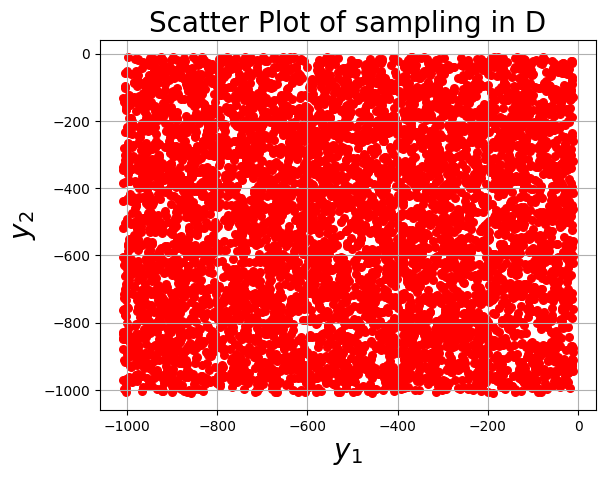

Residual along axis 0 @ value = -505.0: 0.005514520686119795
ax =  1


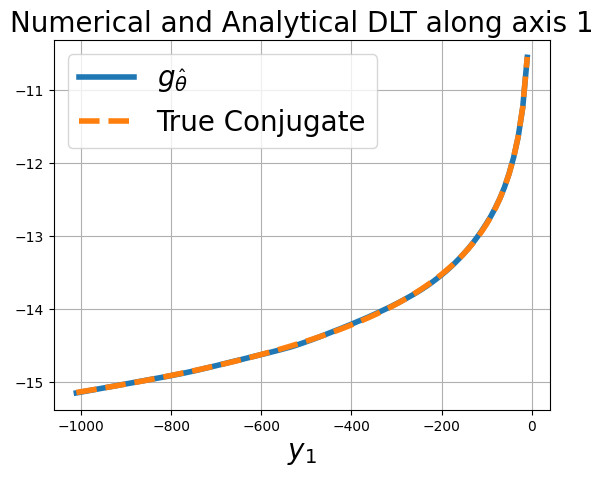

Residual along axis 1 @ value = -505.0: 0.008751953952014446
ax =  2


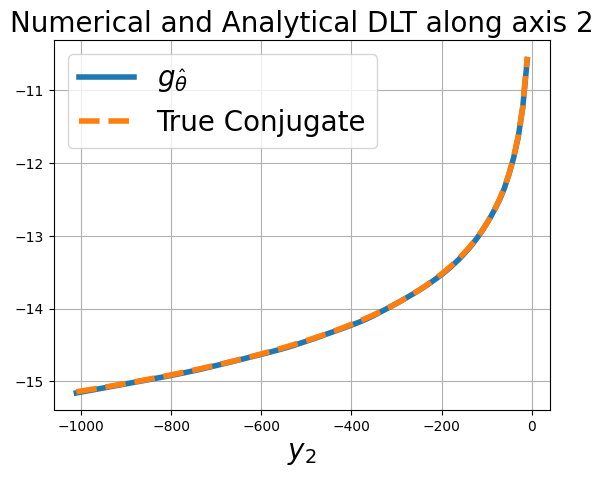

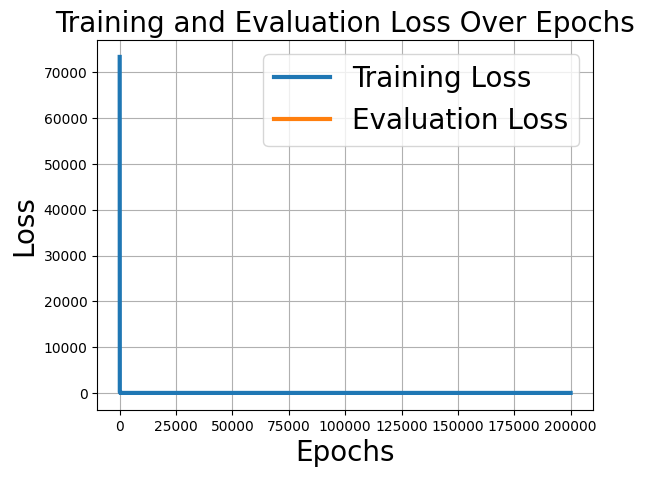

-1000 -10


In [ ]:
const_val = (minval + maxval)/2

plot_results(d, eval_grad_f_x, preds, vmap_f_star_true, state, const_val, train_losses, eval_losses)

print(minval, maxval)

In [ ]:
# loss_list = [float(value) for value in Loss]

# # Print the result
# print(loss_list)

In [ ]:
# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(train_x)
# preds = jnp.squeeze(state.apply_fn({'params': state.params}, eval_grad_f_x)).reshape(-1, 1)
# accuracy,acc_max, residual, mre = calculate_statistics(eval_batch_x, eval_grad_f_x, preds, vmap_f_star_true,  train_loss_list, eval_loss_list)
# print("Accuracy:", accuracy)
# print("Accuracy max norm:", acc_max)
# print("Accuracy, rel:", mre)
# print("Residual:", residual)


Best Evaluation Results:

Evaluation after 199998 epochs:
Train Loss = 0.000036
Eval Loss = 0.000036
Best RMSE = 0.005966 at epoch 199998

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.005966312251985073, Max Accuracy = 0.03135490417480469, RMSE = 0.005966, Mean Relative Error = 0.000350

Measure 'nu' results
Accuracy (y_nu) = 0.0059197451919317245, Max Accuracy (y_nu) = 0.025862693786621094, Mean Relative Error (y_nu) = 0.000345
Additional Test on Test Set 2 after 199998 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.000089
Accuracy 2 = 0.009454213082790375, Max Accuracy 2 = 0.03984355926513672, RMSE 2 = 0.009454, Mean Relative Error 2 = 0.000898

### RESULTS FOR THE DLT PAPER:
d = 2
L2 Accuracy = 0.009454213082790375 (direct sampling)
L-2 Accuracy (y_nu) = 0.0059197451919317245 (target uniform measure)

Train the best example Runtime = 52:00
Total runtime for 200k itereations = 52:00

Autoencoder training runtime: 46.97 seconds
Autoencoder loss: 0.03
